# A/B-тестирование. Принятие решений в бизнесе.

## Описание проекта

В отделе маркетинга крупного интернет-магазина подготовили список гипотез для увеличения выручки.
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

**Задачи проекта:**

Часть 1.

* Расставить приоритет для гипотез методами ICE и RICE, описать различия этих методов, сделать выводы.

Часть 2. Провести анализ А/В теста по данным из задания.


Провести анализ А/В теста по данным из задания.

* Произвести предобработку данных в датафреймах.
* Проверить размеры групп в выборке, понять есть ли разница между ними.
* Проверить, корректно ли был рассчитан размер выборки для проведения теста.
* Произвести анализ выбросов и аномалий, принять решение "удалить или сохранить аномальные данные".
* Произвести анализ кумулятивных метрик по выручке, среднего чека и конверсии.
* Принять решение по результатам А/В теста и объяснить его.

### Описание данных

**Данные для первой части**

Файл /datasets/hypothesis.csv

* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**

Файл /datasets/orders.csv

* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv

* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Выполнение

**Импортирую библиотеки и сохраняю таблицы в переменные:**

In [2]:
# Импорты
import pandas as pd #+
import numpy as np #+
import datetime as dt #+
from matplotlib import pyplot as plt #+
import scipy.stats as stats #+

## Часть 1. Приоритизация гипотез.

**Импортирую данные:**

In [3]:
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')

**Знакомлюсь с гипотезами:**

In [3]:
pd.options.display.max_colwidth = 130

display(hypothesis);

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


**Описание компонентов:**

* Reach — скольких пользователей затронет изменение, которое мы хотим внести;
* Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
* Confidence — насколько мы уверены, что это изменение повлияет на пользователей именно так; 
* Efforts — сколько стоит протестировать эту гипотезу. 

**Решение:**

**Применяю фреймворк ICE для приоритизации гипотез. Сортирую их по убыванию приоритета:**

In [4]:
pd.options.display.max_colwidth = 65

hypothesis['ICE'] = (hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts']

print(round(hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False), 2))

                                                         Hypothesis    ICE
8           Запустить акцию, дающую скидку на товар в день рождения  16.20
0  Добавить два новых канала привлечения трафика, что позволит п...  13.33
7  Добавить форму подписки на все основные страницы, чтобы собра...  11.20
6  Показать на главной странице баннеры с актуальными акциями и ...   8.00
2  Добавить блоки рекомендаций товаров на сайт интернет магазина...   7.00
1  Запустить собственную службу доставки, что сократит срок дост...   2.00
5  Добавить страницу отзывов клиентов о магазине, что позволит у...   1.33
3  Изменить структура категорий, что увеличит конверсию, т.к. по...   1.12
4  Изменить цвет фона главной страницы, чтобы увеличить вовлечен...   1.00


По фреймворку ICE наибольшую оценку имеют гипотезы 8,0 и 7.

**Применяю фреймворк RICE для приоритизации гипотез. Сортирую их по убыванию приоритета:**

Учтём охват изменений и применим фреймворк RICE:

In [5]:
hypothesis['RICE'] = (hypothesis['Impact']*hypothesis['Confidence']*hypothesis['Reach'])/hypothesis['Efforts']

print(hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

                                                         Hypothesis   RICE
7  Добавить форму подписки на все основные страницы, чтобы собра...  112.0
2  Добавить блоки рекомендаций товаров на сайт интернет магазина...   56.0
0  Добавить два новых канала привлечения трафика, что позволит п...   40.0
6  Показать на главной странице баннеры с актуальными акциями и ...   40.0
8           Запустить акцию, дающую скидку на товар в день рождения   16.2
3  Изменить структура категорий, что увеличит конверсию, т.к. по...    9.0
1  Запустить собственную службу доставки, что сократит срок дост...    4.0
5  Добавить страницу отзывов клиентов о магазине, что позволит у...    4.0
4  Изменить цвет фона главной страницы, чтобы увеличить вовлечен...    3.0


После применения фреймворка RICE приоретизация гипотез изменилась. Теперь в приоритете гипотезы 7, 2 и 0. 

**Указываю, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясняю, почему так произошло:**

При применении фреймворка ICE в приоритете гипотезы 8,0 и 7, при применении фреймворка RICE - 7, 2 и 0.

Фреймворк RICE учитывает то, скольких пользователей затронет изменение, которое мы хотим внести.

Так как фреймворк RICE позволяет учесть большее число параметров при расчёте приоритета гипотез, считаю целесообразным установить приоритет гипотез согласно выводу полученному при применении этого фреймворка. В нашем случае наиболее приоритетными гипотезами будут 7, 2, 0.

**Полное название гипотез:**

7 -	Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

2 -	Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.

0 -	Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.


## Часть 2. Анализ A/B-теста

**Мы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv:**

**Импортирую данные:**

In [4]:
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

**Знакомлюсь с данными:**

In [7]:
display(orders.head(5));

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
display(visitors.head(5));

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


**Выполним предобработку данных:**

Вывожу на экран наименования столбцов "orders":

In [9]:
orders.columns

Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')

Необходимо привести названия столбцов и данных в них к "змеиному регистру".

Привожу привести названия столбцов к "змеиному регистру":

In [10]:
orders.columns = ['transactionid', 'visitorid', 'date', 'revenue', 'group']

In [11]:
orders.columns

Index(['transactionid', 'visitorid', 'date', 'revenue', 'group'], dtype='object')

In [12]:
display(orders.head(5));

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Проверяю типы данных и наличие пропусков:

In [13]:
orders.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionid  1197 non-null   int64 
 1   visitorid      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [14]:
orders.shape

(1197, 5)

Изменим тип данных в столбце date:

In [15]:
orders['date'] = pd.to_datetime(orders['date'])

In [16]:
orders.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Проверяю данные на наличие пропусков в каждом отдельном столбце "orders":

In [17]:
orders.isna().sum()

transactionid    0
visitorid        0
date             0
revenue          0
group            0
dtype: int64

Пропусков в orders не обнаружено.

Проверяю "orders" на наличие явных дубликатов:

In [18]:
orders.duplicated().sum()

0

Дубликатов в orders не обнаружено.

Проверим датафрейм visitors:

In [19]:
display(visitors.head(5));

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [20]:
visitors.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Изменим тип данных в столбце date:

In [21]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [22]:
visitors.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [23]:
visitors.shape

(62, 3)

Проверяю данные на наличие пропусков в каждом отдельном столбце "visitors":

In [24]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

Пропусков в visitors не обнаружено.

Проверяю "visitors" на наличие явных дубликатов:

In [25]:
visitors.duplicated().sum()

0

Дубликатов в orders не обнаружено.

Проверку на наличие неявных дубликатов проводить не требуется.

In [26]:
display(orders.head(5));

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [27]:
display(visitors.head(5));

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


* Проверим размеры групп в выборке, есть ли разница между ними.
* Проверим, корректно ли был рассчитан размер выборки для проведения теста.

Кол-во посетителей в группе А: 18736
Кол-во посетителей в группе B: 18916
Кол-во покупок в группе A: 557
Кол-во покупок в группе B: 640


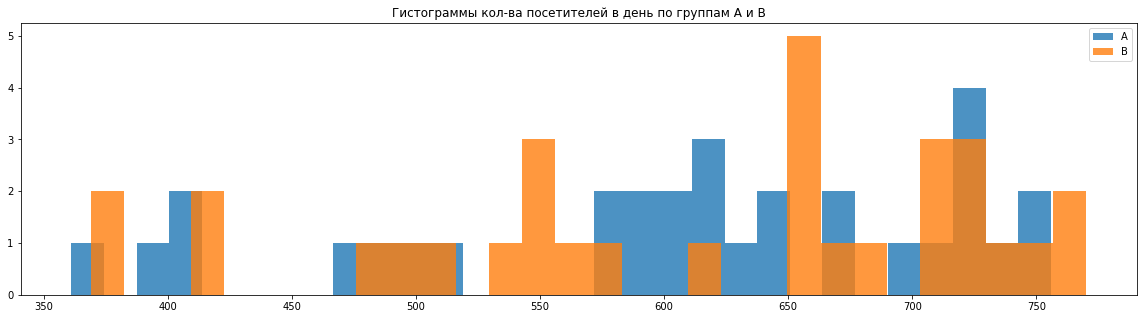

P-value: 0.7301376549390499 
Разница в количестве посетителей в группах A и B статистически НЕ значима.

Начальная конверсия: 0.030
Полученная после изменений конверсия: 0.034
Относительное изменение конверсии после изменений: 0.121

Вводим начальную конверсию и полученное относительное изменение конверсии в калькулятор.
Сайт калькулятора: https://www.evanmiller.org/ab-testing/sample-size.html
Получаем необходимое количество выборки 35269 для корректного проведения тестирования
В нашем случае количество 37652 посещений.
Размер выборки для A/B тестирования подобран корректно, статистически значимой разницы
в количестве посещений ммежду группами не обнаружено.




In [28]:
print('Кол-во посетителей в группе А: {}\n'
      'Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='A']['visitors'].sum(), 
                                                 visitors[visitors['group']=='B']['visitors'].sum()))
purchasesA = len(orders[orders['group']=='A'])
purchasesB = len(orders[orders['group']=='B'])

print('Кол-во покупок в группе A: {}'.format(purchasesA))
print('Кол-во покупок в группе B: {}'.format(purchasesB))

plt.figure(figsize = (20, 5))

plt.hist(visitors[visitors['group']=='A']['visitors'], alpha = 0.8, label='A', bins = 30)
plt.hist(visitors[visitors['group']=='B']['visitors'], alpha = 0.8, label='B', bins = 30)
plt.legend()
plt.title('Гистограммы кол-ва посетителей в день по группам A и B')
plt.show()
results = stats.mannwhitneyu(visitors[visitors['group']=='A']['visitors'], visitors[visitors['group']=='B']['visitors'])
alpha = 0.05

print('P-value: {} '.format(results.pvalue))
if results.pvalue < alpha:
    print('Разница в количестве посетителей в группах A и B статистически значима\n')
else:
    print('Разница в количестве посетителей в группах A и B статистически НЕ значима.\n')

initial_conversion = len(orders[orders['group']=='A']) / visitors[visitors['group']=='A']['visitors'].sum() 
resulting_conversion = len(orders[orders['group']=='B']) / visitors[visitors['group']=='B']['visitors'].sum()

print('Начальная конверсия: {:.3f}'.format(initial_conversion))
print('Полученная после изменений конверсия: {:.3f}'.format(resulting_conversion))
print('Относительное изменение конверсии после изменений: {:.3f}'.format(abs(1-(initial_conversion/resulting_conversion))))
print('\nВводим начальную конверсию и полученное относительное изменение конверсии в калькулятор.\n'
     'Сайт калькулятора: https://www.evanmiller.org/ab-testing/sample-size.html\n'
     'Получаем необходимое количество выборки 35269 для корректного проведения тестирования\n'
     'В нашем случае количество {} посещений.\n'
      'Размер выборки для A/B тестирования подобран корректно, ' 
      'статистически значимой разницы\nв количестве посещений ммежду группами не обнаружено.\n\n'.format(visitors['visitors'].sum()))

Рассчитаем даты начала и окончания теста:

In [29]:
print('\nНачальная дата {}, конечная дата {}\n'.format(visitors['date'].min(), visitors['date'].max()))


Начальная дата 2019-08-01 00:00:00, конечная дата 2019-08-31 00:00:00



Посмотрим сколько групп в A/B тесте:

In [30]:
display(orders['group'].unique());

array(['B', 'A'], dtype=object)

In [31]:
display(visitors['group'].unique());

array(['A', 'B'], dtype=object)

В А/В тесте 2 группы.

In [32]:
display(orders['group'].unique());

array(['B', 'A'], dtype=object)

Рассмотрим количество пользователей в каждой группе по таблице с заказами:

In [33]:
orders.groupby('group').agg({'visitorid': 'nunique'})

,visitorid
group,
A,503
B,586


Разница между группами легко объясняется воздействием на группу В - возможно, причина просто в лучшей конверсии. Если бы это разница была значительной - например, многократной - это было бы признаком проблем. Но в данном случае разница между покупателями не сигнализирует об ошибках в сборе данных.

**Анализирую A/B-тест:**

**1. Строю график кумулятивной выручки по группам. Делаю выводы и предположения:**

1) Создаю датафрейм datesGroups с уникальными парами значений 'date' и 'group', таблицы orders. Избавляюсь от дубликатов методом drop_duplicates().

2) Объявляю переменную ordersAggregated, содержащую:

дату;
группу A/B-теста;
число уникальных заказов в группе теста по указанную дату включительно;
число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
суммарную выручку заказов в группе теста по указанную дату включительно.

3) Объявляю переменную visitorsAggregated, содержащую:

дату;
группу A/B-теста;
количество уникальных посетителей в группе теста по указанную дату включительно.

4) ordersAggregated и visitorsAggregated сортирую по столбцам 'date', 'group' в указанном порядке.

5) Определяю переменную cumulativeData, объединив ordersAggregated и visitorsAggregated по колонкам 'date', 'group' методом merge()

6) Присваиваю столбцам cumulativeData названия ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

7) Вывожу первые 5 строк переменной cumulativeData

In [34]:
datesGroups = orders[['date','group']].drop_duplicates()

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionid' : 'nunique', 'visitorid' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])


visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print('\nПолученная таблица с кумулятивными (накопленными) значениями по дате и группам:'
'\n- Количество покупок \n- Количество покупателей \n- Выручка \n- Количество посетителей')

print(cumulativeData.head(5))



Полученная таблица с кумулятивными (накопленными) значениями по дате и группам:
- Количество покупок 
- Количество покупателей 
- Выручка 
- Количество посетителей
        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


In [35]:
print('\nНачальная дата {}, конечная дата {}\n'.format(visitors['date'].min(), visitors['date'].max()))

print('\nНачальная дата {}, конечная дата {}\n'.format(cumulativeData['date'].min(), cumulativeData['date'].max()))


Начальная дата 2019-08-01 00:00:00, конечная дата 2019-08-31 00:00:00


Начальная дата 2019-08-01 00:00:00, конечная дата 2019-08-31 00:00:00



Минимальная и максимальная даты в датафреймах visitors и cumulativeData совпадают - датафрейм cumulativeData создан корректно.

**Объявим переменные cumulativeRevenueA и cumulativeRevenueB, в которых сохраним данные о датах, выручке и числе заказов в группах A и B.
Построим графики кумулятивной выручки по дням по группам.**

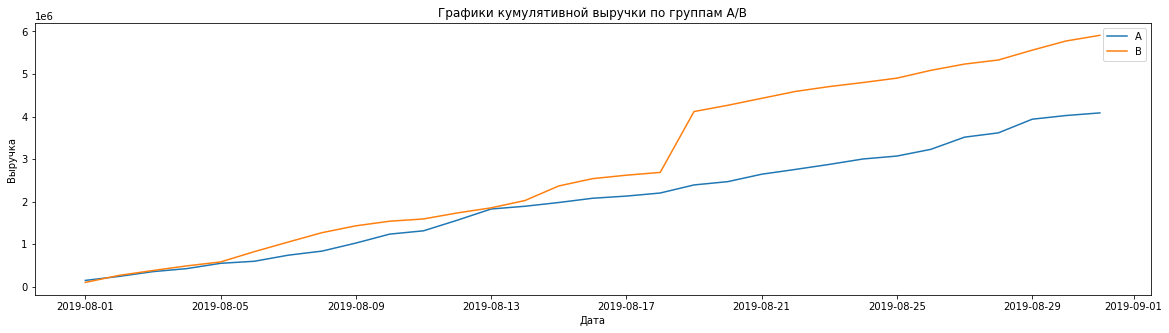

In [36]:
from pandas.plotting import register_matplotlib_converters
import warnings

plt.figure(figsize = (20, 5))

# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]



# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Графики кумулятивной выручки по группам A/B')

plt.legend();

Группа B показывает выручку большую чем группа A, на протяжении всего теста.

После 17.08.2019 на графике группы В виден резкий скачок, который может быть связан с:

* Наличием выброса.
* Резким повышением конверсии.
* Резким повышением среднего чека.

**2. Строю график кумулятивного среднего чека по группам. Делаю выводы и предположения:**

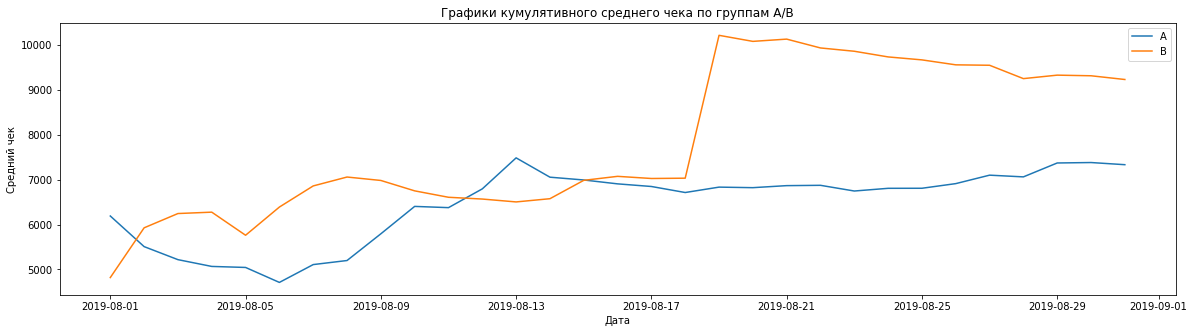

In [37]:
plt.figure(figsize = (20, 5))

cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Графики кумулятивного среднего чека по группам A/B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.legend();

Cредний чек в группе B был выше среднего чека в группе А на протяжении всего теста, за исключением двух недолгих периодов. Во второй половине графика заметно резкое повышение стоимости среднего чека в группе В. Возможно это связано с выбросом.

**3. Строю график относительного изменения кумулятивного среднего чека группы B к группе A. Делаю выводы и предположения:**

Объединим таблицы cumulativeRevenueA и cumulativeRevenueB методом merge() так, чтобы она содержала столбцы: ['date', 'revenueA', 'revenueB', 'ordersA', 'ordersB']. Сохраним в переменной mergedCumulativeRevenue. 
Построим график относительно различия кумулятивного среднего чека группы B к группе A. 
Добавим пунктирную линию оси X (значение оси Y = 0) методом plt.axhline().

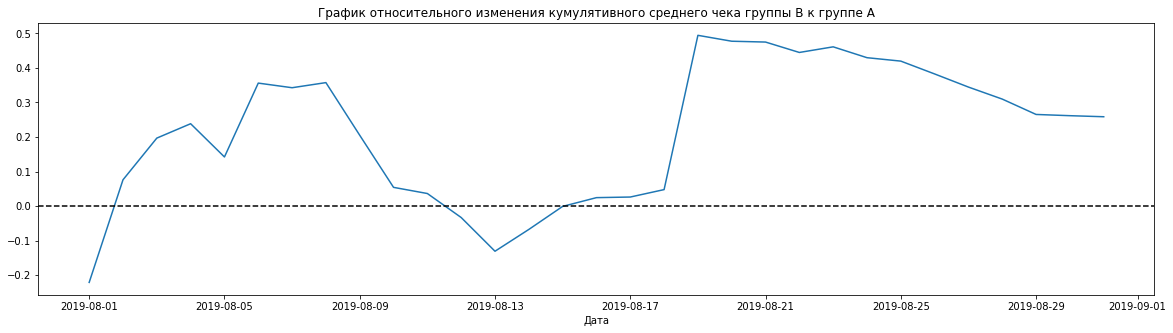

In [38]:
plt.figure(figsize = (20, 5))

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

Колебания слишком резкие - необходимо проверить данные на наличие аномальных пользователей.

**4. Строю график кумулятивного среднего количества заказов на посетителя по группам. Делаю выводы и предположения.**

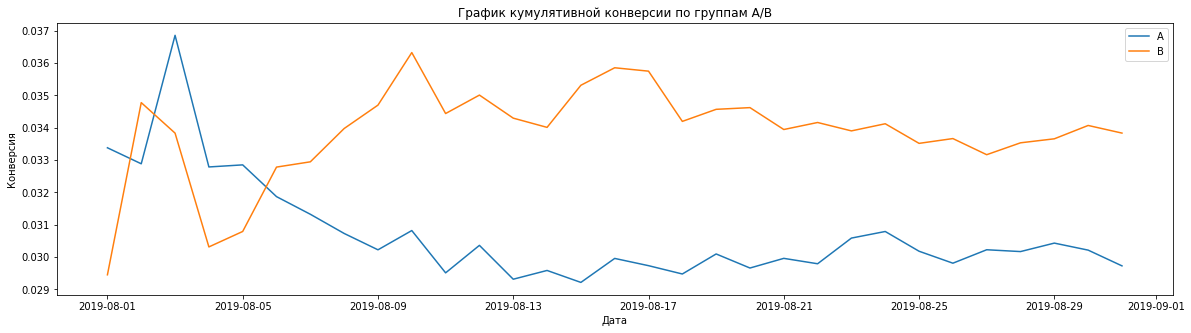

In [39]:
plt.figure(figsize = (20, 5))
cumulativeData['average_order'] = cumulativeData['orders']/cumulativeData['visitors'] 
cumulativeDataA = cumulativeData[cumulativeData['group']=='A'] 
cumulativeDataB = cumulativeData[cumulativeData['group']=='B'] 
plt.plot(cumulativeDataA['date'], cumulativeDataA['average_order'], label='A') 
plt.plot(cumulativeDataB['date'], cumulativeDataB['average_order'], label='B') 
plt.title('График кумулятивной конверсии по группам A/B')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend();

Группа B стабильно показывает большую конверсию чем группа A.

В начале первой недели теста группа А показывала более высокую кумулятивную конверсию, чем группа В. После чего кумулятивная конверсия группы В стала выше, чем в группе А и осталась более высокой, чем в группе А до конца теста. 

В начале первой недели теста в обеих группах виден резкий скачок, а после резкий спад кумулятивной конверсии. 

С 09.08.2019 и до конца теста на графиках заметны плавный спад кумулятивной конверсии группы В, сохраняющийся до конца теста и плавное повышение кумулятивной конверсии группы А, сохраняющееся до конца теста.

**5. Строю график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Делаю выводы и предположения:**

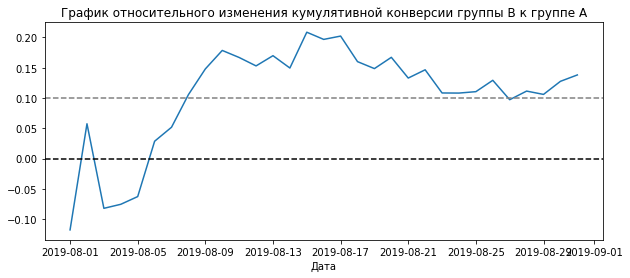

In [40]:
mergedCumulativeData = cumulativeDataA.merge(cumulativeDataB, left_on='date', right_on='date', suffixes=['A', 'B'])
mergedCumulativeData['conversionA'] =  mergedCumulativeData['ordersA'] / mergedCumulativeData['visitorsA'] 
mergedCumulativeData['conversionB'] =  mergedCumulativeData['ordersB'] / mergedCumulativeData['visitorsB']
plt.figure(figsize=(10,4))
plt.plot(mergedCumulativeData['date'], ((mergedCumulativeData['conversionB']/mergedCumulativeData['conversionA'])-1))
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.xlabel('Дата')
plt.show()

Через неделю после начала теста, конверсия в группе В выросла, относительно группы А, примерно на 10% и до конца теста оставалась на этом уровне.

**Анализ выбросов:**

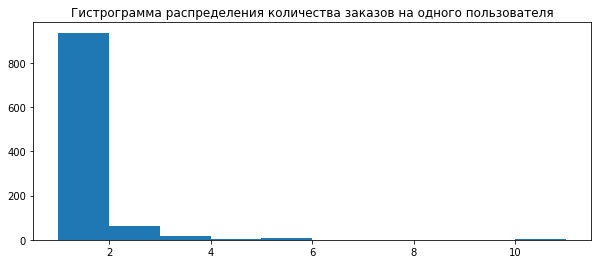

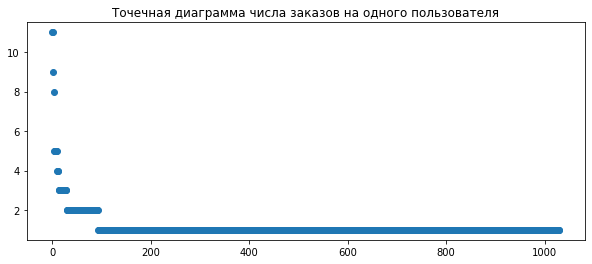

In [41]:
ordersByUsers = orders.groupby('visitorid', as_index = False).agg({'transactionid':'nunique'}).sort_values(by='transactionid', ascending = False)
ordersByUsers.columns = ['visitorid', 'orders']
ordersByUsers.head(5)
plt.figure(figsize=(10,4))
plt.hist(ordersByUsers['orders'], bins = 10)
plt.title('Гистрограмма распределения количества заказов на одного пользователя')
plt.show()
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(10,4))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.show();

Чаще всего пользователи совершают не более 2-х заказов.

**6. Строю точечный график количества заказов по пользователям. Делаю выводы и предположения:**

          userid  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


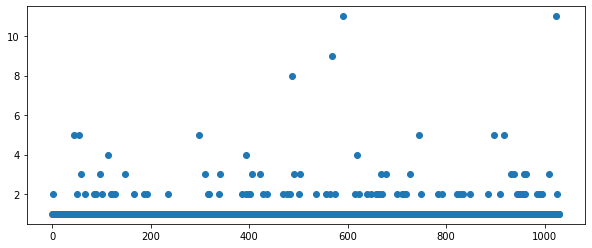

In [42]:
ordersByUsers = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'})
)
ordersByUsers.columns = ['userid', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(10,4))

plt.scatter(x_values, ordersByUsers['orders']);

Обычно пользователи делают не более двух заказов.

**7. Считаю 95-й и 99-й перцентили количества заказов на пользователя. Выбираю границу для определения аномальных пользователей:**

In [43]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) # Метод np.percentile('column', [percentile1, percentile2, percentile3]) находит перцентили.

[1. 2. 4.]


In [44]:
ord_perc = 4

Больше 2-х заказов совершают только 5% пользователей.

**8. Строю точечный график стоимостей заказов.  Делаю выводы и предположения:**

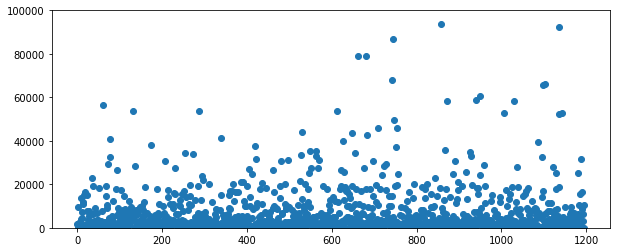

In [45]:
plt.figure(figsize=(10,4))

x_values = pd.Series(range(0, len(orders['revenue'])))

plt.ylim([0, 100000])

plt.scatter(x_values, orders['revenue']);

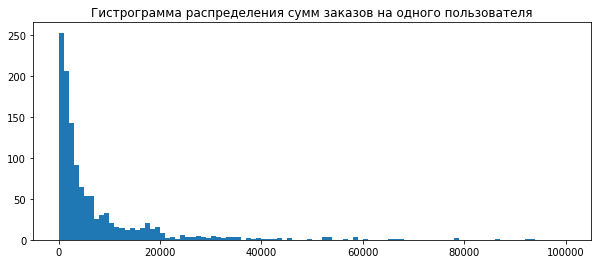

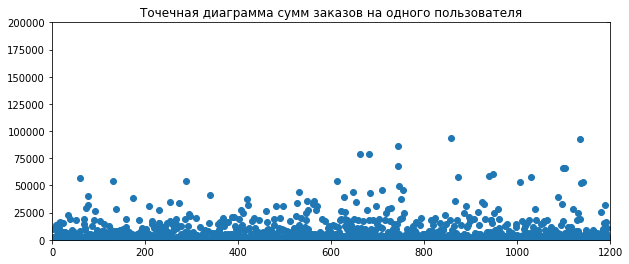

In [46]:
plt.figure(figsize=(10,4))
plt.hist(orders['revenue'], range=(0,100000), bins = 100)
plt.title('Гистрограмма распределения сумм заказов на одного пользователя')
plt.show()
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(10,4))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечная диаграмма сумм заказов на одного пользователя')
plt.axis([0, 1200, 0, 200000])
plt.show()

Большая часть пользователей делает покупки суммой не больше 25000-30000.

**9. Считаю 95-й и 99-й перцентили стоимости заказов. Выбираю границу для определения аномальных заказов:**

In [47]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[18168.  28000.  58233.2]


In [48]:
rev_perc = 58233.2

Только 5% заказов дороже 28000.

**Обозначаю выбранные границы аномалий:**

Определяю границы аномалий по 99 перцентилю :

* 99 перцентиль стоимости заказов равен 58233.2
* 99 перцентиль количества заказов на пользователя равен 4

**10. Считаю статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Делаю выводы и предположения:**

**Формулирую нулевую и альтернативную гипотезы:**

* Нулевая: По неочищенным данным в конверсии групп A и B разница статистически не значима.
* Альтернативная: По неочищенным данным в конверсии групп A и B разница статистически значима.

In [49]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid':'nunique'})
ordersByUsersA.columns = ['visitorId', 'orders']
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid':'nunique'})
ordersByUsersB.columns = ['visitorId', 'orders']

print('Количество покупателей в группе A: {}'.format(len(ordersByUsersA)))
print('Количество покупок в группе А: {}'.format(ordersByUsersA['orders'].sum()))
print('Количество посетителей в группе A: {}\n'.format(visitors[visitors['group']=='A']['visitors'].sum()))
print('Количество покупателей в группе B: {}'.format(len(ordersByUsersB)))
print('Количество покупок в группе B: {}'.format(ordersByUsersB['orders'].sum()))
print('Количество посетителей в группе B: {}'.format(visitors[visitors['group']=='B']['visitors'].sum()))


#составим списки кол-ва заказов sampleA и sampleB со всеми пользователями (в том числе и не купившими) по группам 
list_orders_1 =[]
for i in range(0,(visitors[visitors['group']=='A']['visitors'].sum()-len(ordersByUsersA))):
    list_orders_1.append(0)
orders_by_non_purchased_users_A = pd.Series(data = list_orders_1, name = 'orders')

list_orders_2 =[]
for i in range(0,(visitors[visitors['group']=='B']['visitors'].sum()-len(ordersByUsersB))):
    list_orders_2.append(0)
orders_by_non_purchased_users_B = pd.Series(data = list_orders_2, name = 'orders')

sampleA = pd.concat([ordersByUsersA['orders'], orders_by_non_purchased_users_A], axis=0)
sampleB = pd.concat([ordersByUsersB['orders'], orders_by_non_purchased_users_B], axis=0)
print('\nОтносительный прирост конверсии группы B по отношению к группе A: {:.3f}'.format(sampleB.mean()/sampleA.mean()-1))
alpha = 0.05
results = stats.mannwhitneyu(sampleA, sampleB)
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По неочищенным данным в конверсии групп A и B разница статистически значима.')
else:
    print('По неочищенным данным различий в конверсии групп A и B НЕТ.')

Количество покупателей в группе A: 503
Количество покупок в группе А: 557
Количество посетителей в группе A: 18736

Количество покупателей в группе B: 586
Количество покупок в группе B: 640
Количество посетителей в группе B: 18916

Относительный прирост конверсии группы B по отношению к группе A: 0.138
P-value: 0.016792355056752608
По неочищенным данным в конверсии групп A и B разница статистически значима.


Принимаем альтернативную гипотезу: По неочищенным данным в конверсии групп A и B разница статистически значима.

**11. Считаю статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Делаю выводы и предположения:**

**Формулирую нулевую и альтернативную гипотезы:**

* Нулевая: Различий в средних чеках в группах A и B нет.
* Альтернативная: Различия в средних чеках между группами A и B  есть.

In [50]:
print('Относительное изменение среднего чека в группе B по отношению группы A: {:.3f}'.format(
orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
print('P-value: {}'.format(results.pvalue))

if results.pvalue < alpha:
    print('По неочищенным данным разница в средних чеках в группах A и B статистически значима.')
else:
    print('По неочищенным данным различий в средних чеках в группах A и B нет.')

Относительное изменение среднего чека в группе B по отношению группы A: 0.259
P-value: 0.7292909855432458
По неочищенным данным различий в средних чеках в группах A и B нет.


Принимаем нулевую гипотезу: Различий в средних чеках в группах A и B нет.

**12. Считаю статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Делаю выводы и предположения:**

In [51]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > ord_perc]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > ord_perc]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > rev_perc]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))

print('Количество аномальных пользователей: {}'.format(len(abnormalUsers)));

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
dtype: int64
Количество аномальных пользователей: 15


**Формулирую нулевую и альтернативную гипотезы:**

* Нулевая: По очищенным данным в конверсии групп A и B разница статистически не значима.
* Альтернативная: По очищенным данным в конверсии групп A и B разница статистически значима.

In [52]:
sampleAFiltered = pd.concat([
    ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
    orders_by_non_purchased_users_A
], axis = 0)
sampleBFiltered = pd.concat([
    ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
    orders_by_non_purchased_users_B
], axis = 0)
print('\nОтносительный прирост конверсии группы B по отношению к группе A после очистки данных: {:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По очищенным данным в конверсии групп A и B разница статистически значима.')
else:
    print('По очищенным данным различий в конверсии групп A и B нет.')


Относительный прирост конверсии группы B по отношению к группе A после очистки данных: 0.153
P-value: 0.014380135585307981
По очищенным данным в конверсии групп A и B разница статистически значима.


Принимаем альтернативную гипотезу: По очищенным данным в конверсии групп A и B разница статистически значима.

**13. Считаю статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Делаю выводы и предположения:**

**Формулирую нулевую и альтернативную гипотезы:**

* Нулевая: По очищенным данным различий в средних чеках в группах A и B нет.
* Альтернативная: По очищенным данным различия в средних чеках между группами А и В есть.

In [53]:
print('Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: {:.3f}'.format(
orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean()\
/orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean()-1))
       
       
results = stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'],
                             orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'])
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По очищенным данным разница в средних чеках в группах A и B статистически значима.')
else:
    print('По очищенным данным различий в средних чеках в группах A и B нет.')

Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: -0.006
P-value: 0.8509126191381939
По очищенным данным различий в средних чеках в группах A и B нет.


Принимаем нулевую гипотезу: По очищенным данным различий в средних чеках в группах A и B нет.

**14. Принимаю решение по результатам теста и объясняю его. Варианты решений:**

1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

**Общие выводы:**

* Выборка данных имеет корректный размер.
* Количество аномальных пользователей: 15
* Группа В показывает лучшие результаты кумулятивных метрик по выручке, среднему чеку и конверсии. 
* После очистки данных мы убедились в том, что разница между средними чеками минимальна - это даёт нам уверенность в том, что тест и его результаты корректны.
* Разница показателей конверсии между группами и до и после очистки данных является статистически значимой, что пользволяет нам сделать вывод о том, что мы можем остановить A/B тест и зафиксировать победу группы B.